imports

In [1]:
from __future__ import print_function, division
from builtins import range

import os
import sys,re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, GlobalMaxPool1D, Bidirectional, Conv1D
from tensorflow.keras.layers import LSTM, MaxPooling1D, Embedding, Dropout, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.metrics import roc_auc_score

some configuration

In [2]:
MAX_SEQUENCE_LENGTH = 200
MAX_VOCAB_SIZE = 30000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 6

load in pre-trained word vectors

In [3]:
word2vec = {}
with open(os.path.join('/home/hassan/Documents/machine_learning_examples/nlp_class3/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec


In [4]:
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.


prepare text samples and their labels

In [5]:
sentences = np.empty(0,dtype='object')
targets = np.zeros((0,7))
labels = { "ArtOrDet":0,"Nn":1,"Vt":2,"Prep":3,"Vform":4,"Wform":5,"SVA":6 }
i=0
f=open('/home/hassan/Documents/machine_learning_examples/nlp_class3/toxic/conll14st-preprocessed.m2')
line = f.readline()
while line:
    line = line.strip()
    if line:
        # print(line)
        if re.search("^S",line):
            a=np.empty(1,dtype='object')
            a[0]=line[2:]
            sentences=np.concatenate([sentences,a])
            b=np.zeros((1,7))
            targets=np.concatenate([targets,b])
            i=i+1
        elif re.search("^A",line):
            # print("found annotation")
            for key in labels:
                # print(labels.get(key))
                if re.search(key,line):
                    # print(labels.get(key))
                    targets[i-1,labels.get(key)]=1
                    break
    line=f.readline()



In [6]:
f=open('/home/hassan/Documents/GEC_/toxic/official-2014.combined-withalt.m2')
line = f.readline()
while line:
    line = line.strip()
    if line:
        # print(line)
        if re.search("^S",line):
            a=np.empty(1,dtype='object')
            a[0]=line[2:]
            sentences=np.concatenate([sentences,a])
            b=np.zeros((1,7))
            targets=np.concatenate([targets,b])
            i=i+1
        elif re.search("^A",line):
            # print("found annotation")
            for key in labels:
                # print(labels.get(key))
                if re.search(key,line):
                    # print(labels.get(key))
                    targets[i-1,labels.get(key)]=1
                    break
    line=f.readline()



In [49]:
print(targets[3])
print(targets[58462])
print("found line", i)

Moreover , as elderly are prone to illnesses and accidents , they might suffer from severe falls and strokes .
[1. 1. 0. 1. 0. 1. 1.]
found line 58463


convert the sentences (strings) into integers

In [8]:
tokenizer = Tokenizer( num_words=MAX_VOCAB_SIZE, filters='\t\n')
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

word2idx = tokenizer.word_index

In [9]:
print("sequence[0]: ", sequences[0])

print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
# s = sorted(len(s) for s in sequences)
# print("median sequence length:", s[len(s) // 2])
#
# print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

print('Found %s unique tokens.' % len(word2idx))
# print(next(iter(word2idx)))

sequence[0]:  [1080, 9, 7501, 242]
max sequence length: 227
min sequence length: 1
Found 29750 unique tokens.


pad sequences so that we get a N x T matrix

In [18]:

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


In [44]:
print("data[0]", data[0])
print('Shape of data tensor:', data.shape)

data[0] [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    

In [24]:
indices = np.random.permutation(data.shape[0])
training_idx, test_idx = indices[:52463], indices[52463:]
x_training, x_test = data[training_idx,:], data[test_idx,:]

In [48]:
print(y_training[0])
print(training_idx[1])

[1. 0. 0. 0. 0. 0. 0.]
32111


In [38]:
[word for word, index in word2idx.items() if index == 39 ]

['elderly']

In [45]:
print(training_idx[0])
y_training, y_test = targets[training_idx,:], targets[test_idx,:]

36297


In [52]:
del sentences
del sequences
del targets
del data

prepare embedding matrix <br/>
Filling pre-trained embeddings...

In [53]:
print("len word2idx", len(word2idx))
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector


Filling pre-trained embeddings...
len word2idx 29750


In [54]:
print("embedding_matrix shape:", embedding_matrix.shape)
print(word2idx.get("creating"))
print("embedding_matrix[1113]", embedding_matrix[1113])

embedding_matrix shape: (29751, 100)
1080
embedding_matrix[1113] [ 0.062497   -0.67212999  0.20155001  0.094727    0.29690999  0.32301
 -0.21544001 -0.10883     0.35653999  0.0769     -0.29014999 -0.28364
  0.45517999 -0.17453     0.23957001 -0.49955001  0.26804999  0.48311001
 -0.71631998  0.16308001  0.85055     0.40685001 -0.21877    -0.89292002
 -0.037749    0.13072    -0.005088   -0.45372999 -0.58617997 -0.13279
  0.06173     0.56757998 -0.031886   -0.1569      0.30113     0.089954
  0.40274999  0.17216     0.22866    -1.33809996  1.16110003 -0.63685
  0.088577   -0.50928003 -0.30388999  0.27311     0.29042    -0.084582
  0.15349001  0.07679     0.52596998 -0.22392    -0.58911997  0.39482999
  0.16959    -0.57401001 -0.058901   -0.22863001  1.29400003 -0.24248999
 -0.29561999 -0.78558999  0.46970999  0.34156999  0.14144     0.16636001
  0.21919    -0.66413999  0.63117999 -0.045638   -0.72386003  0.078425
  0.45379999 -0.24975     0.38626     1.21179998  0.50875998 -0.63848001
 -0.

load pre-trained word embeddings into an Embedding layer <br/>
note that we set trainable = False so as to keep the embeddings fixed <br/>
Building Embedding layer ...

In [55]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

Building Embedding layer ...


Building model...

In [56]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = Dense(256, activation='relu')(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
# x = Dropout(0.2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.2)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
# x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output = Dense(7, activation='sigmoid')(x)
#this takes waay too much time
model = Model(input_, output)

In [57]:
model.compile(
   loss='binary_crossentropy',
   optimizer='adam',
   metrics=['accuracy']
)

In [58]:
print('Training model...')
r = model.fit(
  x_training,
  y_training,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/6
328/328 [==============================] - 59s 179ms/step - loss: 0.1993 - accuracy: 0.8046 - val_loss: 0.1871 - val_accuracy: 0.8534
Epoch 2/6
328/328 [==============================] - 61s 185ms/step - loss: 0.1812 - accuracy: 0.8411 - val_loss: 0.1815 - val_accuracy: 0.8534
Epoch 3/6
328/328 [==============================] - 60s 182ms/step - loss: 0.1787 - accuracy: 0.8253 - val_loss: 0.1830 - val_accuracy: 0.8532
Epoch 4/6
328/328 [==============================] - 59s 179ms/step - loss: 0.1764 - accuracy: 0.8190 - val_loss: 0.1771 - val_accuracy: 0.8140
Epoch 5/6
328/328 [==============================] - 57s 175ms/step - loss: 0.1732 - accuracy: 0.7698 - val_loss: 0.1849 - val_accuracy: 0.6803
Epoch 6/6
328/328 [==============================] - 61s 187ms/step - loss: 0.1693 - accuracy: 0.7074 - val_loss: 0.1784 - val_accuracy: 0.6754


In [59]:
e = model.evaluate(
    x_test,
    y_test
)

188/188 [==============================] - 3s 16ms/step - loss: 0.1786 - accuracy: 0.6748


plot some data

In [60]:
%matplotlib inline

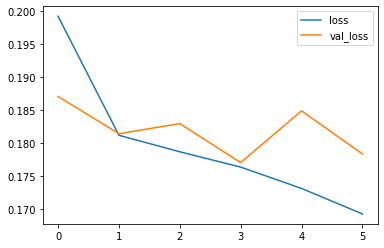

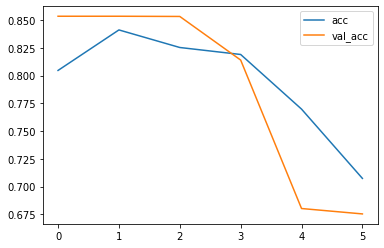

In [61]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()


In [64]:
p = model.predict(x_training)
aucs = []
for j in range(6):
    auc = roc_auc_score(y_training[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))
print("this sucks")

0.8001206359427747
this sucks
